In [1]:
import pandas as pd


df = pd.read_csv('http://bit.ly/kaggletrain')

In [2]:
df.shape

(891, 12)

In [3]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.corr()['Survived'].sort_values(ascending = False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

<AxesSubplot:>

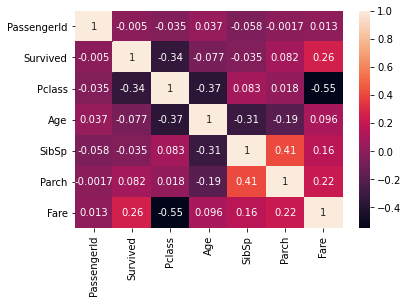

In [6]:
import seaborn as sns
sns.heatmap(df.corr(), annot = True)

<AxesSubplot:xlabel='Parch'>

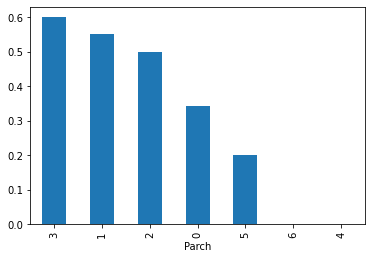

In [7]:
df.groupby('Parch')['Survived'].mean().sort_values(ascending = False).plot(kind = 'bar')

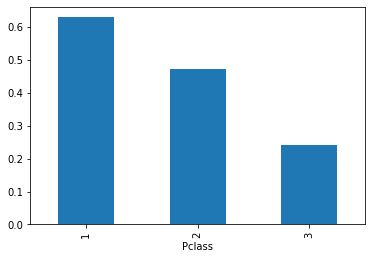

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


df.groupby('Pclass')['Survived'].mean().sort_values(ascending = False).plot(kind = 'bar')
plt.show()

In [9]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
#Want to perform feature engineering but first select columns of importance.
df = df.loc[df.Embarked.notna(), ['Survived', 'Parch','Pclass', 'Age','Fare','Sex', 'Embarked']]

In [11]:
df.head()

,Survived,Parch,Pclass,Age,Fare,Sex,Embarked
0,0,0,3,22.0,7.2500,male,S
1,1,0,1,38.0,71.2833,female,C
2,1,0,3,26.0,7.9250,female,S
3,1,0,1,35.0,53.1000,female,S
4,0,0,3,35.0,8.0500,male,S


In [12]:
#Want to select X values
X = df.drop('Survived', axis = 1)
y = df.Survived

In [13]:
X.shape

(889, 6)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

log_model = LogisticRegression(solver = 'liblinear')

In [15]:
#cross_val_score(log_model, X, y, cv = 5, scoring = 'accuracy').mean()

In [16]:
y.value_counts(normalize=True)

0    0.617548
1    0.382452
Name: Survived, dtype: float64

In [17]:
#Want to now transform data and perform feature engineering to improve model accuracy
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline

trans_columns = make_column_transformer((OneHotEncoder(), ['Sex', 'Embarked']), (SimpleImputer(strategy = 'median'), ['Age']), remainder = 'passthrough')
trans_columns.fit_transform(X)

array([[ 0.    ,  1.    ,  0.    , ...,  0.    ,  3.    ,  7.25  ],
       [ 1.    ,  0.    ,  1.    , ...,  0.    ,  1.    , 71.2833],
       [ 1.    ,  0.    ,  0.    , ...,  0.    ,  3.    ,  7.925 ],
       ...,
       [ 1.    ,  0.    ,  0.    , ...,  2.    ,  3.    , 23.45  ],
       [ 0.    ,  1.    ,  1.    , ...,  0.    ,  1.    , 30.    ],
       [ 0.    ,  1.    ,  0.    , ...,  0.    ,  3.    ,  7.75  ]])

In [18]:
pipe = make_pipeline(trans_columns, log_model)
cross_val_score(pipe, X, y, cv = 5, scoring = 'accuracy').mean()

0.7953024820669079

In [50]:
#Want to create a pre-processing function for selecting numeric correlated variables
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

#Variance threshold would appear to be a poor way of reducing dimensionality given significant column variance disparities
#for index, vari in df.var().values:
 #   selector = VarianceThreshold(threshold = )
pipe = Pipeline(steps = [('hot', make_column_transformer((OneHotEncoder(), ['Sex', 'Embarked']), remainder = 'passthrough')), ('simp', SimpleImputer(strategy = "most_frequent")), ('scaler', MinMaxScaler())])
X = df.drop('Survived', axis = 1)
print(X.columns)
X = pipe.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

""" Doesn't seem like a particulary useful strategy for feature selection
lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=4, step=1)
rfe.fit(X, y)
rfe.ranking_
"""

#Use SelectFromModel to select the most important features from the dataset with the intention of passing them to neural net
print(X.shape)
estimator = LogisticRegression().fit(X_train,y_train)
selector = SelectFromModel(estimator = estimator, threshold = "mean", prefit = True)
transformed = selector.transform(X)
X_train,X_test,y_train,y_test=train_test_split(transformed,y,test_size=0.3,random_state=0)




Index(['Parch', 'Pclass', 'Age', 'Fare', 'Sex', 'Embarked'], dtype='object')
(889, 9)


In [51]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, normalize
from kerastuner import HyperModel
from tensorflow import keras
from tensorflow.keras import layers


def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [52]:
#Not really sure why this produces an incompatability error but interesting to monitor going forward. Probably don't need to dimensionality reduce anyways
"""
tuner_rs = RandomSearch(
            build_model,
            objective='val_accuracy',
            max_trials=3,
            executions_per_trial=3)

tuner_rs.search(X_train, y_train, epochs=25, validation_data = (X_test,y_test), verbose=1)

best_model = tuner_rs.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)
"""

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


ValueError: in user code:

    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1233 test_function  *
        return step_function(self, iterator)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1217 run_step  **
        outputs = model.test_step(data)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1183 test_step
        y_pred = self(x, training=False)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1008 __call__
        self._maybe_build(inputs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2710 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\core.py:1192 build
        trainable=True)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:639 add_weight
        caching_device=caching_device)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\base.py:810 _add_variable_with_custom_getter
        **kwargs_for_getter)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py:142 make_variable
        shape=variable_shape if variable_shape else None)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py:221 _variable_v1_call
        shape=shape)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py:714 variable_capturing_scope
        lifted_initializer_graph=lifted_initializer_graph, **kwds)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py:227 __init__
        initial_value = initial_value()
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\base.py:82 __call__
        self._checkpoint_position, shape, shard_info=shard_info)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\base.py:117 __init__
        self.wrapped_value.set_shape(shape)
    C:\Users\ncole\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1217 set_shape
        (self.shape, shape))

    ValueError: Tensor's shape (9, 352) is not compatible with supplied shape [4, 352]


In [ ]:
#Want to now use hyper-parameter tuning to increase model accuracy.
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Create a pipeline



pipe = Pipeline(steps = [('hot', make_column_transformer((OneHotEncoder(), ['Sex', 'Embarked']), remainder = 'passthrough')), ('simp', SimpleImputer(strategy = "most_frequent")), ('scaler', MinMaxScaler())])

X = df.drop('Survived', axis = 1)
X = pipe.fit_transform(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)


# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [{"n_estimators": [10, 100, 1000],
                "max_depth":[5,8,15,25,30,None],
                "min_samples_leaf":[1,2,5,10,15,100],
                "max_leaf_nodes": [2, 5,10]}]
#create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(RandomForestClassifier(), grid_param, cv=5, verbose=1,n_jobs=-1) 
# Fit grid search
best_model = gridsearch.fit(X_train,y_train)
best_model.score(X_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min


In [56]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel


#pipe2 = make_pipeline(trans_columns, LogisticRegression())
pipe = Pipeline(steps = [('hot', make_column_transformer((OneHotEncoder(), ['Sex', 'Embarked']), remainder = 'passthrough')), ('simp', SimpleImputer(strategy = "most_frequent")), ('scaler', MinMaxScaler())])
X = df.drop('Survived', axis = 1)
y = df.Survived
X = pipe.fit_transform(X, y = None)

#Feature Selection
#from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
#from sklearn.svm import SVC

print(X.shape)
lsvc = LinearSVC(C=0.3, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.3,random_state=0)

print(X_train.shape)


#selector = SequentialFeatureSelector(SVC(C = .1),direction = 'forward', cv = 5)
#X = selector.fit_transform(X)

# Create dictionary with candidate hyperparameters after fitting model
grid_param = [
                {
                 "criterion": ['gini','entropy'],
                "n_estimators": [10, 100, 1000],
                "max_depth":[5,8,15,25,30,None],
                "min_samples_leaf":[1,2,5,10,15,100],
                "max_leaf_nodes": [2, 5,10]
                }]

# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(RandomForestClassifier(), grid_param, cv=5, verbose=1,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_train,y_train)
best_model.score(X_test, y_test)

(889, 9)
(622, 7)
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    9.2s


KeyboardInterrupt: 

In [ ]:
#Perform Comparison with deep learning model and keras tuner

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, normalize
from kerastuner import HyperModel
from tensorflow import keras
from tensorflow.keras import layers


def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [28]:
#Create custom sequential pipeline for deep learning throughput
from kerastuner.tuners.randomsearch import RandomSearch
from kerastuner.tuners.bayesian import BayesianOptimization
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

pipe = Pipeline(steps = [('hot', make_column_transformer((OneHotEncoder(), ['Sex', 'Embarked']), remainder = 'passthrough')), ('simp', SimpleImputer(strategy = "most_frequent")), ('scaler', MinMaxScaler())])
X = df.drop('Survived', axis = 1)
y = df.Survived
X = pipe.fit_transform(X, y = None)

print(X.shape)
#Incorporating feature selection though need to recognize that it is linearly based
#lsvc = LinearSVC(C=0.5, penalty="l1", dual=False).fit(X, y)
#model = SelectFromModel(lsvc, prefit=True)
#X_new = model.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

print(X_train.shape[1])





input_shape = (X_train.shape[1],)

tuner_rs = RandomSearch(
            build_model,
            objective='val_accuracy',
            max_trials=3,
            executions_per_trial=3)

tuner_rs.search(X_train, y_train, epochs=25, validation_data = (X_test,y_test), verbose=1)

best_model = tuner_rs.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)

(889, 9)
9


NameError: name 'build_model' is not defined

In [30]:
tuner_rs = BayesianOptimization(
            build_model,
            overwrite = True,
            objective='val_loss',
            max_trials=3,
            executions_per_trial=3)

tuner_rs.search(X_train, y_train, epochs=25, validation_data = (X_test,y_test), verbose=1)

best_model = tuner_rs.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)

Trial 3 Complete [00h 00m 27s]
val_loss: 0.4835963745911916

Best val_loss So Far: 0.4835963745911916
Total elapsed time: 00h 01m 32s
INFO:tensorflow:Oracle triggered exit
9/9 [==============================] - 1s 3ms/step - loss: 0.5038 - accuracy: 0.7693


In [31]:
m = RFECV(RandomForestClassifier(), scoring='accuracy')
m.fit(X_train, y_train)

RFECV(estimator=RandomForestClassifier(), scoring='accuracy')

In [32]:
#Disparity between in sample and out of sample scoring is large due to small sample size
in_sample = m.score(X_train, y_train)
out_sample = m.score(X_test, y_test)
diff = in_sample - out_sample
print(diff)

0.18081698519936895
